# Import package

In [1]:
library(forecast)

Warning message:
"package 'forecast' was built under R version 3.6.3"Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Registered S3 method overwritten by 'xts':
  method     from
  as.zoo.xts zoo 
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 


# Load dataset

In [2]:
data <- read.csv('Data.csv')

In [3]:
summary(data)

      Date            Mkt.RF              SMB                HML         
 Min.   :196307   Min.   :-23.2400   Min.   :-15.3900   Min.   :-13.920  
 1st Qu.:197803   1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -1.395  
 Median :199212   Median :  0.9250   Median :  0.1050   Median :  0.230  
 Mean   :199248   Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.300  
 3rd Qu.:200708   3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.700  
 Max.   :202204   Max.   : 16.1000   Max.   : 18.3800   Max.   : 12.740  
      RMW                CMA                RF             NoDur        
 Min.   :-18.7600   Min.   :-6.7800   Min.   :0.0000   Min.   :-21.020  
 1st Qu.: -0.8175   1st Qu.:-1.0000   1st Qu.:0.1400   1st Qu.: -1.242  
 Median :  0.2400   Median : 0.1100   Median :0.3800   Median :  1.080  
 Mean   :  0.2752   Mean   : 0.2947   Mean   :0.3641   Mean   :  1.049  
 3rd Qu.:  1.2775   3rd Qu.: 1.4900   3rd Qu.:0.5100   3rd Qu.:  3.720  
 Max.   : 13.3800   Max.   : 9.0600   Max.  

# Train & Predict

#### Lấy dữ liệu

In [21]:
series <- ts(data = data$Utils, start = c(1963,7), end = c(2022,4), frequency = 12)
X <- ts(data = data[,2:7], start = c(1963,7), end = c(2022,4), frequency = 12)[,-3]

In [22]:
series %>% summary()

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
-13.0100  -1.4200   0.9150   0.8424   3.2775  18.8400 

In [23]:
X %>% summary()

     Mkt.RF              SMB                RMW                CMA         
 Min.   :-23.2400   Min.   :-15.3900   Min.   :-18.7600   Min.   :-6.7800  
 1st Qu.: -1.9600   1st Qu.: -1.5400   1st Qu.: -0.8175   1st Qu.:-1.0000  
 Median :  0.9250   Median :  0.1050   Median :  0.2400   Median : 0.1100  
 Mean   :  0.5648   Mean   :  0.2214   Mean   :  0.2752   Mean   : 0.2947  
 3rd Qu.:  3.4000   3rd Qu.:  2.0650   3rd Qu.:  1.2775   3rd Qu.: 1.4900  
 Max.   : 16.1000   Max.   : 18.3800   Max.   : 13.3800   Max.   : 9.0600  
       RF        
 Min.   :0.0000  
 1st Qu.:0.1400  
 Median :0.3800  
 Mean   :0.3641  
 3rd Qu.:0.5100  
 Max.   :1.3500  

#### Khảo sát tập train từ 7/1963 - 12/1989

In [24]:
log_scale <- function(x) {log(1+x/100)} #scaler
log_inv <- function(x) {(exp(x)-1)*100} #inverter

In [25]:
series_train <- series %>% window(end=c(1989,12)) %>% log_scale()
X_train <- X %>% window(end=c(1989,12)) %>% log_scale()

In [26]:
series_train %>% summary()

     Min.   1st Qu.    Median      Mean   3rd Qu.      Max. 
-0.129995 -0.015799  0.004938  0.007690  0.031184  0.172608 

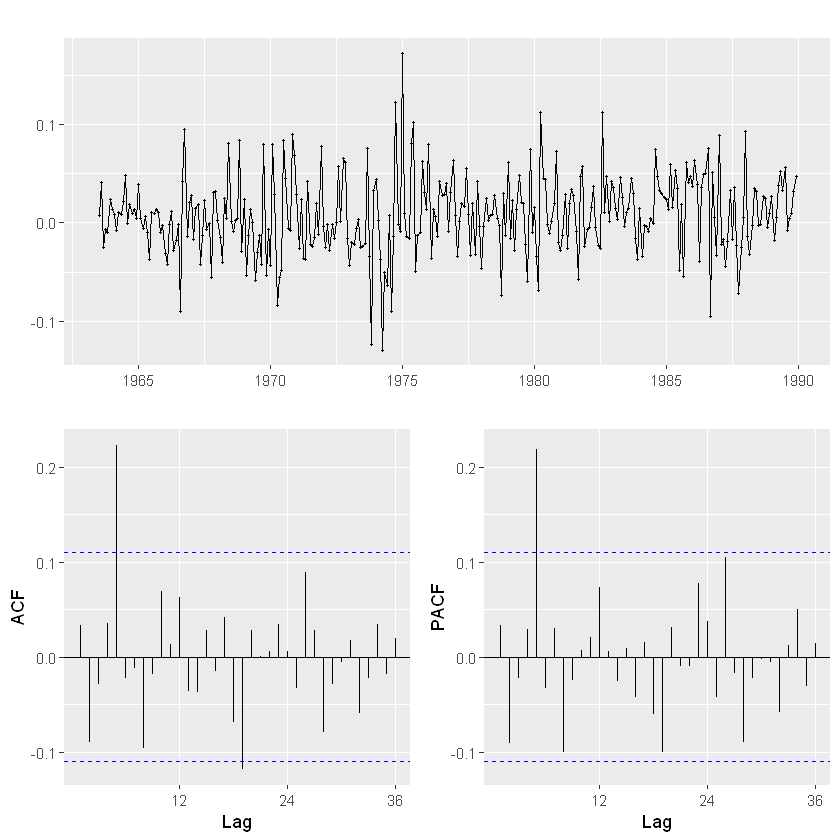

In [27]:
series_train %>% ggtsdisplay()

#### Chọn tham số cho mô hình Dynamic

In [28]:
auto.arima(y = series_train, xreg = X_train, stepwise = FALSE, approximation = FALSE)

Series: series_train 
Regression with ARIMA(2,0,2) errors 

Coefficients:
         ar1      ar2      ma1     ma2  Mkt.RF      SMB      RMW     CMA
      0.6958  -0.9110  -0.6468  0.8284  0.6998  -0.2692  -0.4871  0.0333
s.e.  0.0617   0.0812   0.0861  0.1144  0.0357   0.0530   0.1164  0.1032
          RF
      1.3948
s.e.  0.2494

sigma^2 estimated as 0.0006579:  log likelihood=718.12
AIC=-1416.23   AICc=-1415.52   BIC=-1378.61

In [29]:
fit <- Arima(y = series_train, xreg = X_train, order = c(2,0,2))

In [30]:
fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
true <- ts(data = fit$x, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv

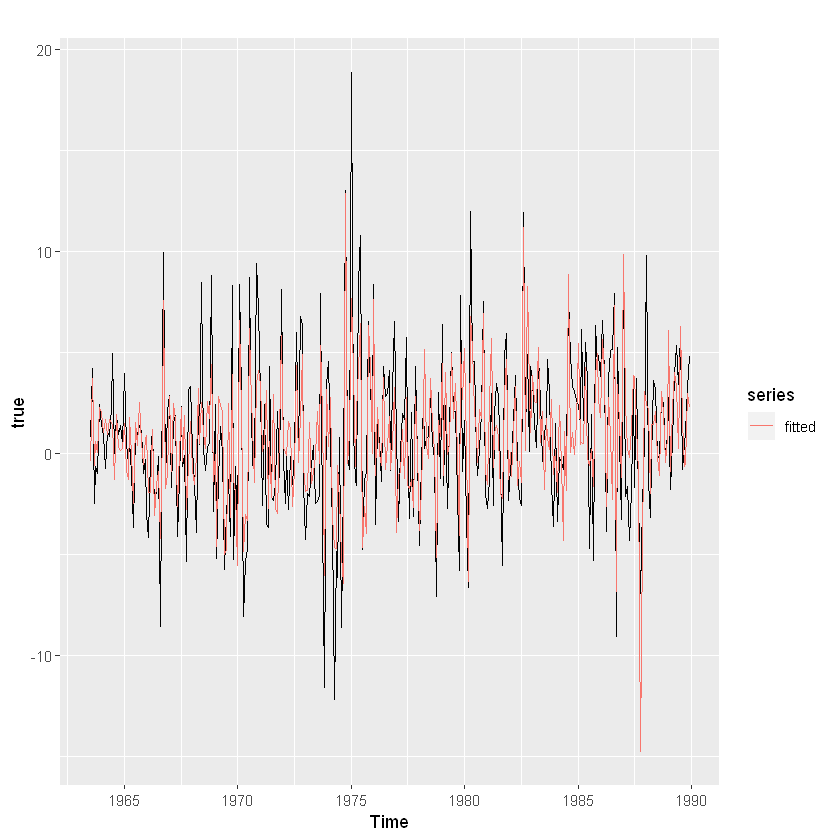

In [31]:
autoplot(true)+autolayer(fitted)

In [32]:
(true - fitted)^2 %>% mean %>% sqrt

[1] 2.541631

#### Chạy thử một số bộ ARIMA trên tập train

In [33]:
order <- list(ARIMA000 = c(0,0,0), ARIMA001 = c(0,0,1), ARIMA002 = c(0,0,2), ARIMA003 = c(0,0,3),
              ARIMA100 = c(1,0,0), ARIMA101 = c(1,0,1), ARIMA102 = c(1,0,2), ARIMA103 = c(1,0,3),
              ARIMA200 = c(2,0,0), ARIMA201 = c(2,0,1), ARIMA202 = c(2,0,2), ARIMA203 = c(2,0,3))

In [34]:
result <- NULL
for (o in order)
{
    fit <- Arima(y = series_train, xreg = X_train, order = o)
    fitted <- ts(data = fit$fitted, start = c(1963,7), end = c(1989,12), frequency = 12) %>% log_inv
    rmse <- sqrt(mean((log_inv(series_train) - fitted)^2))
    result <- rbind(result, c(AIC = fit$aic, AICc = fit$aicc, BIC = fit$bic, RMSE = rmse))
}
row.names(result) <- names(order)
result

,AIC,AICc,BIC,RMSE
ARIMA000,-1411.453,-1411.092,-1385.119,2.592997
ARIMA001,-1410.991,-1410.525,-1380.894,2.586706
ARIMA002,-1409.291,-1408.706,-1375.432,2.584879
ARIMA003,-1413.697,-1412.980,-1376.076,2.562389
ARIMA100,-1410.854,-1410.388,-1380.758,2.587365
ARIMA101,-1409.048,-1408.464,-1375.190,2.586339
ARIMA102,-1408.271,-1407.554,-1370.650,2.581039
ARIMA103,-1412.277,-1411.415,-1370.895,2.559998
ARIMA200,-1409.861,-1409.276,-1376.002,2.582242
ARIMA201,-1409.069,-1408.352,-1371.448,2.577740


#### Predict & đánh giá RMSE

In [35]:
pred <- NULL
for (i in 0:387)
{
    train <- series %>% subset(end=length(series)-388+i) %>% log_scale()
    reg <- X %>% subset(end=length(series)-388+i) %>% log_scale()
    fit <- Arima(y = train, xreg = reg, order = c(2,0,2))
    newreg <- X %>% subset(start=length(series)-387+i, end=length(series)-387+i) %>% log_scale()
    pred_val <- forecast(fit, h = 1, xreg = newreg)$mean %>% log_inv()
    pred <- c(pred, pred_val)
}
pred <- ts(pred, start=c(1990,1), frequency = 12)
true <- series %>% window(start=c(1990,1))
rmse <- sqrt(mean((true-pred)^2))

In [36]:
rmse

[1] 3.508971

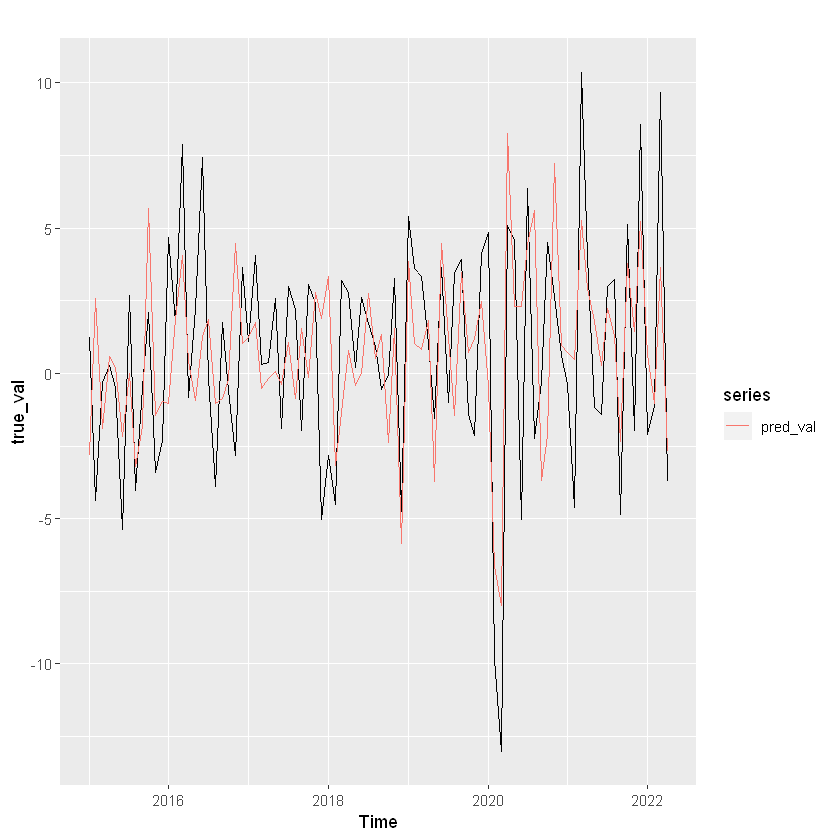

In [37]:
true_val <- true %>% window(start = c(2015,1))
pred_val <- pred %>% window(start = c(2015,1))
autoplot(true_val) + autolayer(pred_val)